# Calculating time scales for *cis/trans* isomerization


In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pickle
import pandas as pd
from joblib import Parallel, delayed
from tqdm import tqdm
import os

In [2]:
os.makedirs('autocoorel_data', exist_ok=True)

## Load Important Function

In [3]:
class Data:
    def __init__(self, array_list):
        self.array_list = array_list

    def save(self, filename):
        with open(filename, 'wb') as f:
            pickle.dump(self.array_list, f)

    @classmethod
    def load(cls, filename):
        with open(filename, 'rb') as f:
            array_list = pickle.load(f)
        return cls(array_list)

In [4]:
def omega2cistrans(omega):
    """Converts a sequence of float omega angles (in degrees) to an array of ints: 0 cis and 1 trans."""
    
    shifted_omega = (omega + 90.0) % 360.0 - 90.0 # shift into (-90, 270) range to avoid periodic boundaries
    
    cistrans = np.where(shifted_omega > 90.0, 1, 0).astype(int)
    return cistrans

## Load in the omega angle trajectories by result

In [4]:
# Parameters
residues_to_plot = [0, 1, 2]  # Residues to plot
num_residues = len(residues_to_plot)

save_dir = 'omega_data'
all_omega = Data.load(f"{save_dir}/all_omega.pkl").array_list  # This is an (742, x, 3) array
# Convert each array in the list to float
all_omega = [arr.astype(float) for arr in all_omega]

# Apply omega2cistrans() to each array in all_omega
all_cistrans = [omega2cistrans(arr) for arr in all_omega]

# Print shape of the first converted array for verification
print(f"First array shape after conversion: {all_cistrans[0].shape}")
all_cistrans[0]

First array shape after conversion: (9002, 3)


array([[1, 1, 1],
       [0, 1, 1],
       [0, 1, 1],
       ...,
       [0, 1, 1],
       [0, 0, 1],
       [0, 0, 1]])

#### compile transition probabilities as a function of lag time (in steps)

In [8]:
def compute_transition_matrix(subset, num_states, lagtime, pseudocount=0.25):
    """Compute transition matrix for a given subset of trajectories."""
    
    C = np.zeros((num_states, num_states))  # Initialize count matrix

    for traj in subset:
        for t in range(len(traj) - lagtime):
            from_state = traj[t]
            to_state = traj[t + lagtime]

            # Skip NaN transitions
            if np.isnan(from_state) or np.isnan(to_state):
                continue

            # Convert states to integers for indexing
            from_state = int(from_state)
            to_state = int(to_state)

            # Count transitions
            C[from_state, to_state] += 1.0

    # Add pseudocounts to avoid zero entries
    C += pseudocount

    # Normalize rows to get probabilities
    row_sums = C.sum(axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1  # Prevent division by zero
    T = C / row_sums        
    
    return T

In [9]:
def compute_stationary_distribution(T, lagtime):
    """Compute the stationary distribution of a transition matrix T.
    
    INPUT:
    T - Transition matrix where T_ij is the probability of transitioning i -> j.
    
    RETURN:
    pi - The stationary distribution (1D NumPy array).
    t2 - The implied timescale (in units of steps).
    """
    try:
        # Compute the implied timescale
        evals = np.linalg.eigvals(T.transpose() )  # will be something like [0.99754545 1.        ]
        evals_sorted = np.sort(evals)      # ascending order
        mu2 = evals_sorted[-2]            # second-largest eigenvalue
        #print('mu2', mu2, 'evals', evals, 'evals_sorted', evals_sorted, 'T', T)
        
        t2 = -1.0*lagtime/np.log(mu2.real)  # the implied timescale relation
        #print('evals_sorted', evals_sorted, 'mu2', mu2, 't2', t2)

        # Compute the stationary state distribution 
        n_states = T.shape[0]
        A = np.transpose(T) - np.eye(n_states)  # (T' - I)
        A = np.vstack([A, np.ones(n_states)])  # Append normalization row
        b = np.zeros(n_states + 1)
        b[-1] = 1  # Ensure probability sums to 1
        
        # Solve for stationary distribution using least squares
        pi, *_ = np.linalg.lstsq(A, b, rcond=None)
        
        # Ensure non-negative values and normalize
        pi = np.maximum(pi, 0)  # Prevent small negative values due to numerical error
        pi /= np.sum(pi)  # Normalize to sum to 1

    except Exception as e:
        print(f"Error computing stationary distribution: {e}")
        t2 = np.nan
        pi = None

    return pi, t2

In [10]:
def get_transition_matrices(n_trajs, num_states, lagtime, cluster_size=10, pseudocount=0.25, n_jobs=-1):
    """
    Compute transition matrices for subsets of trajectories in parallel.
    """

    num_trajs = n_trajs.shape[0]  # Number of trajectories
    
    # Shuffle indices
    indices = np.arange(num_trajs)
    np.random.shuffle(indices)

    # Split into clusters
    clusters = [indices[i:i + cluster_size] for i in range(0, num_trajs, cluster_size)]

    # Merge last small cluster with the second-last if needed
    if len(clusters) > 1 and len(clusters[-1]) < cluster_size:
        clusters[-2] = np.concatenate([clusters[-2], clusters[-1]])  
        clusters.pop()

    # Parallel computation of transition matrices
    def process_cluster(cluster):
        subset = n_trajs[cluster]
        # Call your existing compute_transition_matrix
        T = compute_transition_matrix(subset, num_states, lagtime, pseudocount)
        return T

    # Use joblib's Parallel for parallelism. 
    # `delayed(process_cluster)(c)` calls `process_cluster(c)` lazily.
    # `n_jobs=-1` uses all available CPUs unless specified otherwise.
    transition_matrices = Parallel(n_jobs=n_jobs)(
        delayed(process_cluster)(cluster) 
        for cluster in tqdm(clusters, desc="Computing transition matrices", unit="cluster")
    )

    return transition_matrices


In [11]:
def process_trajectory(n_trajs, lagtime, num_states, cluster_size):

    # Calculate the transition matrix 
    transition_matrices = get_transition_matrices(n_trajs, num_states, lagtime, cluster_size, pseudocount=0.25, n_jobs=-1)
    transition_matrices = np.array(transition_matrices)
    print('transition_matrices.shape', transition_matrices.shape)
    print(transition_matrices)

    # Calculate the stationary population 
    pi_all = []
    t2_all = []

    
    for T in transition_matrices:
        pi, t2 = compute_stationary_distribution(T, lagtime)
        pi_all.append(pi)
        t2_all.append(t2)

    pi_all = np.array(pi_all)
    t2_all = np.array(t2_all)


    t2_mean = np.exp(np.nanmean([np.log(t2) for t2 in t2_all]))  # Geometric mean
    t2_std = np.exp(np.sqrt(np.nanvar([np.log(t2) for t2 in t2_all])))  # Geometric std dev
    pi_means = np.nanmean(pi_all, axis=0)  # Mean across trajectories
    pi_std = np.nanstd(pi_all, axis=0)  # Standard deviation
    
    print('t2_mean, pi_means:', t2_mean, pi_means)
    return pi_means, pi_std, t2_mean, t2_std, transition_matrices

#print(pi_all)

## Let's make an implied timescale plot for each omega angle

In [5]:
## Create a nah filling array where to make sure all the traj are the same length

ntraj = len(all_omega)

# Find the longest traj
maxlength = max( [ len(all_cistrans[i]) for i in range(ntraj) ])
print('maxlength', maxlength)

# Make an array to store all the trajectories
traj = np.nan * np.ones( (ntraj, maxlength, 3) )

for i in range(ntraj):
    n = len(all_cistrans[i])
    traj[i, 0:n, :] = all_cistrans[i]

traj


maxlength 37002


array([[[ 1.,  1.,  1.],
        [ 0.,  1.,  1.],
        [ 0.,  1.,  1.],
        ...,
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]],

       [[ 1.,  1.,  1.],
        [ 1.,  1.,  1.],
        [ 1.,  1.,  1.],
        ...,
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]],

       [[ 1.,  1.,  1.],
        [ 1.,  1.,  1.],
        [ 1.,  1.,  1.],
        ...,
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]],

       ...,

       [[ 1.,  1.,  1.],
        [ 0.,  1.,  1.],
        [ 0.,  1.,  1.],
        ...,
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]],

       [[ 1.,  1.,  1.],
        [ 0.,  1.,  1.],
        [ 0.,  1.,  1.],
        ...,
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]],

       [[ 1.,  1.,  1.],
        [ 1.,  1.,  1.],
        [ 1.,  1.,  1.],
        ...,
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]]

(37002, 3)


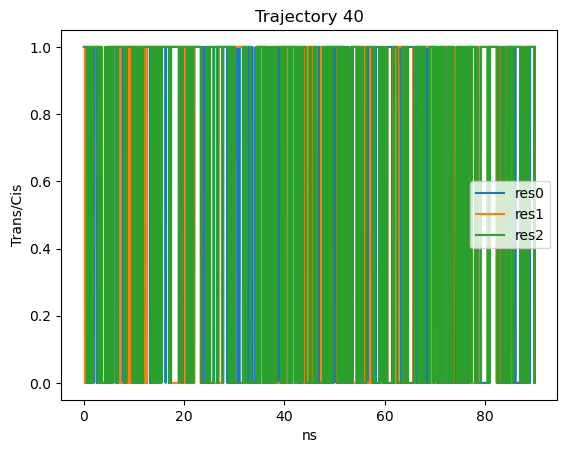

(37002, 3)


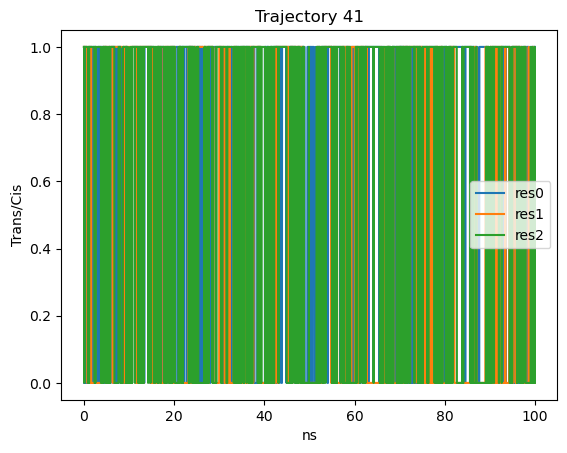

(37002, 3)


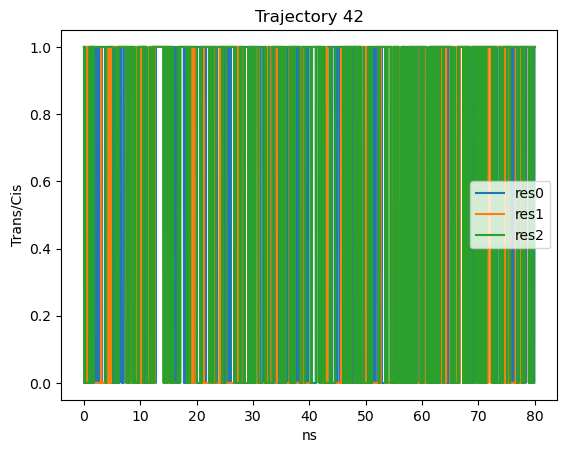

(37002, 3)


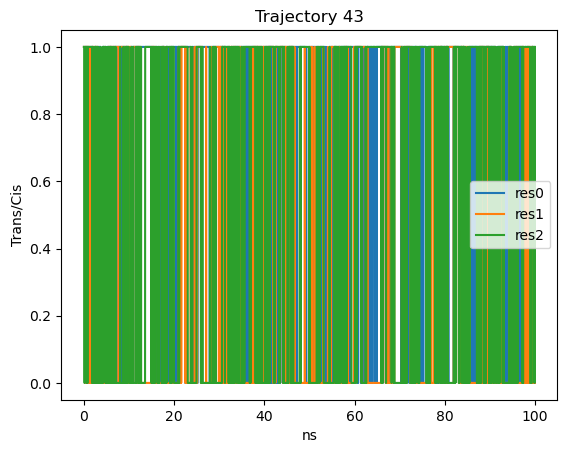

(37002, 3)


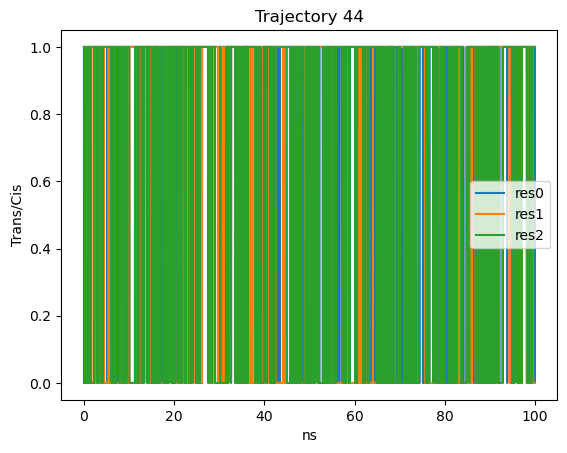

In [8]:
step_to_plot = np.arange(0, 10000)  # Corrected step range
dt_in_ns = 0.01 # 10 ps to 1 ns

for i in range(40, 45):
    print(traj[i].shape)
    plt.plot(step_to_plot * dt_in_ns, traj[i][step_to_plot, 0], label='res0')  # X component
    plt.plot(step_to_plot * dt_in_ns, traj[i][step_to_plot, 1], label='res1')  # Y component
    plt.plot(step_to_plot * dt_in_ns, traj[i][step_to_plot, 2], label='res2')  # Z component
    
    plt.xlabel("ns")
    plt.ylabel("Trans/Cis")
    plt.legend(loc='best')  # Automatically places the legend in the best position
    plt.title(f"Trajectory {i}")
    plt.show()

### Calculating the implied timescale and stationary population

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

dt_in_ns = 0.01
residues = [0, 1, 2]

n_result = len(all_omega)  # Ensure all_omega is defined
n_trajs = traj  # Ensure traj is defined

num_states = 2
#lagtimes = [5, 10, 25, 50]
lagtimes = [5, 10, 25, 50] + list(range(100, 40000, 500))
cluster_size = 10

# Store results with proper shape: (n_residues, n_lagtimes)
pi_all_means = []
pi_all_stds = []
t2_all_means = []
t2_all_stds = []
transition_matrices_all_res = []

for residue in residues:
    print(f'Processing residue {residue} with lagtimes = {lagtimes}')
    
    pi_means_res = []
    pi_stds_res = []
    t2_means_res = []
    t2_stds_res = []
    transition_matrices_res = []
    
    for lagtime in tqdm(lagtimes, desc="Processing Lag Times", unit="lag"):
        pi_means, pi_std, t2_mean, t2_std, transition_matrices= process_trajectory(n_trajs[:, :, residue], lagtime, num_states, cluster_size)
        
        pi_means_res.append(pi_means)
        pi_stds_res.append(pi_std)
        t2_means_res.append(t2_mean)
        t2_stds_res.append(t2_std)

    # Append per-residue results
    pi_all_means.append(pi_means_res)
    pi_all_stds.append(pi_stds_res)
    t2_all_means.append(t2_means_res)
    t2_all_stds.append(t2_stds_res)
    transition_matrices_all_res.append(transition_matrices)

# Convert to NumPy arrays for easier indexing
pi_all_means = np.array(pi_all_means)  # Shape: (n_residues, n_lagtimes)
pi_all_stds = np.array(pi_all_stds)
t2_all_means = np.array(t2_all_means)
t2_all_stds = np.array(t2_all_stds)
transition_matrices_all_res = np.array(transition_matrices_all_res)

lagtimes_ns = np.array(lagtimes) * dt_in_ns


Processing residue 0 with lagtimes = [5, 10, 25, 50, 100, 600, 1100, 1600, 2100, 2600, 3100, 3600, 4100, 4600, 5100, 5600, 6100, 6600, 7100, 7600, 8100, 8600, 9100, 9600, 10100, 10600, 11100, 11600, 12100, 12600, 13100, 13600, 14100, 14600, 15100, 15600, 16100, 16600, 17100, 17600, 18100, 18600, 19100, 19600, 20100, 20600, 21100, 21600, 22100, 22600, 23100, 23600, 24100, 24600, 25100, 25600, 26100, 26600, 27100, 27600, 28100, 28600, 29100, 29600, 30100, 30600, 31100, 31600, 32100, 32600, 33100, 33600, 34100, 34600, 35100, 35600, 36100, 36600, 37100, 37600, 38100, 38600, 39100, 39600]


Processing Lag Times:   1%|          | 1/84 [00:08<11:27,  8.28s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.68966577 0.31033423]
  [0.13348746 0.86651254]]

 [[0.69547259 0.30452741]
  [0.1348675  0.8651325 ]]

 [[0.67236478 0.32763522]
  [0.13836331 0.86163669]]

 [[0.67652734 0.32347266]
  [0.13263849 0.86736151]]

 [[0.67193182 0.32806818]
  [0.13745414 0.86254586]]

 [[0.67292438 0.32707562]
  [0.13486292 0.86513708]]

 [[0.66547763 0.33452237]
  [0.13298006 0.86701994]]

 [[0.67572108 0.32427892]
  [0.13470372 0.86529628]]]
t2_mean, pi_means: 8.179384760746615 [0.29507224 0.70492776]


Processing Lag Times:   2%|▏         | 2/84 [00:10<06:43,  4.92s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.57377079 0.42622921]
  [0.18082229 0.81917771]]

 [[0.57984947 0.42015053]
  [0.17606308 0.82393692]]

 [[0.57963318 0.42036682]
  [0.17706027 0.82293973]]

 [[0.59156961 0.40843039]
  [0.17333871 0.82666129]]

 [[0.56181456 0.43818544]
  [0.17903218 0.82096782]]

 [[0.56862422 0.43137578]
  [0.1809296  0.8190704 ]]

 [[0.56865749 0.43134251]
  [0.17397044 0.82602956]]

 [[0.57689007 0.42310993]
  [0.1789515  0.8210485 ]]]
t2_mean, pi_means: 10.842116786328035 [0.29471046 0.70528954]


Processing Lag Times:   4%|▎         | 3/84 [00:13<05:09,  3.82s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.43058912 0.56941088]
  [0.23873455 0.76126545]]

 [[0.42275058 0.57724942]
  [0.24653001 0.75346999]]

 [[0.41909066 0.58090934]
  [0.2388138  0.7611862 ]]

 [[0.41694451 0.58305549]
  [0.23806075 0.76193925]]

 [[0.40967302 0.59032698]
  [0.24537052 0.75462948]]

 [[0.40654246 0.59345754]
  [0.24764927 0.75235073]]

 [[0.42802927 0.57197073]
  [0.24277421 0.75722579]]

 [[0.42585263 0.57414737]
  [0.24234623 0.75765377]]]
t2_mean, pi_means: 14.450271773162934 [0.2948461 0.7051539]


Processing Lag Times:   5%|▍         | 4/84 [00:15<04:28,  3.35s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.32996692 0.67003308]
  [0.27666934 0.72333066]]

 [[0.33084059 0.66915941]
  [0.26841632 0.73158368]]

 [[0.32005934 0.67994066]
  [0.27369545 0.72630455]]

 [[0.34688682 0.65311318]
  [0.28697393 0.71302607]]

 [[0.34376165 0.65623835]
  [0.28149471 0.71850529]]

 [[0.32608744 0.67391256]
  [0.27420804 0.72579196]]

 [[0.34357983 0.65642017]
  [0.28707827 0.71292173]]

 [[0.34777062 0.65222938]
  [0.27409027 0.72590973]]]
t2_mean, pi_means: 17.556278880585058 [0.29504479 0.70495521]


Processing Lag Times:   6%|▌         | 5/84 [00:18<04:07,  3.13s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.30360508 0.69639492]
  [0.28766796 0.71233204]]

 [[0.29830722 0.70169278]
  [0.29195715 0.70804285]]

 [[0.3002883  0.6997117 ]
  [0.29060114 0.70939886]]

 [[0.30138746 0.69861254]
  [0.28683504 0.71316496]]

 [[0.31612616 0.68387384]
  [0.29888328 0.70111672]]

 [[0.300103   0.699897  ]
  [0.28642773 0.71357227]]

 [[0.30222007 0.69777993]
  [0.2934393  0.7065607 ]]

 [[0.31800812 0.68199188]
  [0.28768594 0.71231406]]]
t2_mean, pi_means: 23.21598517781761 [0.29473893 0.70526107]


Computing transition matrices: 100%|██████████| 8/8 [00:00<00:00, 2225.98cluster/s]
/var/folders/2g/yfyfpy7d3n3fwl_23ytkftvm0000gn/T/ipykernel_1528/606344109.py:18: RuntimeWarning: invalid value encountered in log
  t2 = -1.0*lagtime/np.log(mu2.real)  # the implied timescale relation
Processing Lag Times:   7%|▋         | 6/84 [00:21<03:47,  2.91s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.31125601 0.68874399]
  [0.30339278 0.69660722]]

 [[0.30432952 0.69567048]
  [0.3036335  0.6963665 ]]

 [[0.30273127 0.69726873]
  [0.30701939 0.69298061]]

 [[0.29619735 0.70380265]
  [0.29411953 0.70588047]]

 [[0.28683765 0.71316235]
  [0.28912213 0.71087787]]

 [[0.28847794 0.71152206]
  [0.28523972 0.71476028]]

 [[0.30037441 0.69962559]
  [0.2939729  0.7060271 ]]

 [[0.28769157 0.71230843]
  [0.28456614 0.71543386]]]
t2_mean, pi_means: 104.25122678237325 [0.29575468 0.70424532]


Processing Lag Times:   8%|▊         | 7/84 [00:23<03:29,  2.72s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.28614453 0.71385547]
  [0.28708871 0.71291129]]

 [[0.28221308 0.71778692]
  [0.28889648 0.71110352]]

 [[0.2966456  0.7033544 ]
  [0.29409511 0.70590489]]

 [[0.29501971 0.70498029]
  [0.29328279 0.70671721]]

 [[0.30172025 0.69827975]
  [0.29365841 0.70634159]]

 [[0.29459624 0.70540376]
  [0.29923614 0.70076386]]

 [[0.29617398 0.70382602]
  [0.2939224  0.7060776 ]]

 [[0.30118605 0.69881395]
  [0.30335313 0.69664687]]]
t2_mean, pi_means: 190.34590855513076 [0.29420233 0.70579767]


Processing Lag Times:  10%|▉         | 8/84 [00:26<03:27,  2.73s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.30417932 0.69582068]
  [0.29179907 0.70820093]]

 [[0.30187504 0.69812496]
  [0.30081383 0.69918617]]

 [[0.29666831 0.70333169]
  [0.31170495 0.68829505]]

 [[0.28777446 0.71222554]
  [0.28792159 0.71207841]]

 [[0.27525916 0.72474084]
  [0.29034782 0.70965218]]

 [[0.29445156 0.70554844]
  [0.2847672  0.7152328 ]]

 [[0.28583344 0.71416656]
  [0.2917778  0.7082222 ]]

 [[0.30204112 0.69795888]
  [0.3053718  0.6946282 ]]]
t2_mean, pi_means: 308.5285501220897 [0.29494407 0.70505593]


Processing Lag Times:  11%|█         | 9/84 [00:28<03:23,  2.72s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.30260323 0.69739677]
  [0.30529402 0.69470598]]

 [[0.28215906 0.71784094]
  [0.28458736 0.71541264]]

 [[0.29954775 0.70045225]
  [0.29886604 0.70113396]]

 [[0.29403874 0.70596126]
  [0.29967527 0.70032473]]

 [[0.29723057 0.70276943]
  [0.30427751 0.69572249]]

 [[0.2994809  0.7005191 ]
  [0.28291803 0.71708197]]

 [[0.29059936 0.70940064]
  [0.29031859 0.70968141]]

 [[0.29667975 0.70332025]
  [0.29288783 0.70711217]]]
t2_mean, pi_means: 345.61442229908863 [0.29495903 0.70504097]


Processing Lag Times:  12%|█▏        | 10/84 [00:31<03:08,  2.55s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.30075453 0.69924547]
  [0.2933803  0.7066197 ]]

 [[0.2927256  0.7072744 ]
  [0.28860543 0.71139457]]

 [[0.29086006 0.70913994]
  [0.29567688 0.70432312]]

 [[0.30608557 0.69391443]
  [0.2948161  0.7051839 ]]

 [[0.29380472 0.70619528]
  [0.2875593  0.7124407 ]]

 [[0.30302455 0.69697545]
  [0.29473183 0.70526817]]

 [[0.28207658 0.71792342]
  [0.30522812 0.69477188]]

 [[0.29146025 0.70853975]
  [0.29955222 0.70044778]]]
t2_mean, pi_means: 526.307014068707 [0.29497841 0.70502159]


Processing Lag Times:  13%|█▎        | 11/84 [00:33<03:00,  2.47s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.31384988 0.68615012]
  [0.29252518 0.70747482]]

 [[0.28490061 0.71509939]
  [0.28666578 0.71333422]]

 [[0.28962171 0.71037829]
  [0.28327717 0.71672283]]

 [[0.3002981  0.6997019 ]
  [0.29624201 0.70375799]]

 [[0.29723469 0.70276531]
  [0.27796405 0.72203595]]

 [[0.29932153 0.70067847]
  [0.30353431 0.69646569]]

 [[0.31289166 0.68710834]
  [0.30646941 0.69353059]]

 [[0.29418441 0.70581559]
  [0.30177993 0.69822007]]]
t2_mean, pi_means: 668.9104359056796 [0.29515454 0.70484546]


Processing Lag Times:  14%|█▍        | 12/84 [00:35<02:56,  2.45s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.31269711 0.68730289]
  [0.29302031 0.70697969]]

 [[0.28462892 0.71537108]
  [0.28963661 0.71036339]]

 [[0.30329431 0.69670569]
  [0.2961711  0.7038289 ]]

 [[0.28763497 0.71236503]
  [0.29990666 0.70009334]]

 [[0.30376924 0.69623076]
  [0.29545903 0.70454097]]

 [[0.30226984 0.69773016]
  [0.29974208 0.70025792]]

 [[0.29822292 0.70177708]
  [0.29678562 0.70321438]]

 [[0.29893511 0.70106489]
  [0.28781512 0.71218488]]]
t2_mean, pi_means: 714.3256775222612 [0.29604538 0.70395462]


Processing Lag Times:  15%|█▌        | 13/84 [00:38<02:56,  2.48s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.30350344 0.69649656]
  [0.29813442 0.70186558]]

 [[0.29101124 0.70898876]
  [0.30227898 0.69772102]]

 [[0.28317708 0.71682292]
  [0.29264968 0.70735032]]

 [[0.30050476 0.69949524]
  [0.30515751 0.69484249]]

 [[0.28724399 0.71275601]
  [0.28516823 0.71483177]]

 [[0.28638889 0.71361111]
  [0.30420749 0.69579251]]

 [[0.29348952 0.70651048]
  [0.29548735 0.70451265]]

 [[0.30041951 0.69958049]
  [0.29931939 0.70068061]]]
t2_mean, pi_means: 679.196520380928 [0.29643662 0.70356338]


Processing Lag Times:  17%|█▋        | 14/84 [00:40<02:52,  2.46s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.29251559 0.70748441]
  [0.29444729 0.70555271]]

 [[0.29634489 0.70365511]
  [0.29760341 0.70239659]]

 [[0.28461821 0.71538179]
  [0.28674129 0.71325871]]

 [[0.30600304 0.69399696]
  [0.29925005 0.70074995]]

 [[0.27466358 0.72533642]
  [0.29846782 0.70153218]]

 [[0.30967709 0.69032291]
  [0.29446759 0.70553241]]

 [[0.32036081 0.67963919]
  [0.299804   0.700196  ]]

 [[0.3054267  0.6945733 ]
  [0.29377749 0.70622251]]]
t2_mean, pi_means: 1054.7057407447091 [0.29655094 0.70344906]


Processing Lag Times:  18%|█▊        | 15/84 [00:44<03:05,  2.69s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.30312584 0.69687416]
  [0.30510959 0.69489041]]

 [[0.28275171 0.71724829]
  [0.28868793 0.71131207]]

 [[0.29456279 0.70543721]
  [0.29542181 0.70457819]]

 [[0.30449453 0.69550547]
  [0.29829143 0.70170857]]

 [[0.28794194 0.71205806]
  [0.28832922 0.71167078]]

 [[0.30491391 0.69508609]
  [0.28182648 0.71817352]]

 [[0.29760178 0.70239822]
  [0.31077893 0.68922107]]

 [[0.3020482  0.6979518 ]
  [0.30021884 0.69978116]]]
t2_mean, pi_means: 1031.8495797077355 [0.29637775 0.70362225]


Processing Lag Times:  18%|█▊        | 15/84 [00:44<03:24,  2.96s/lag]


KeyboardInterrupt: 

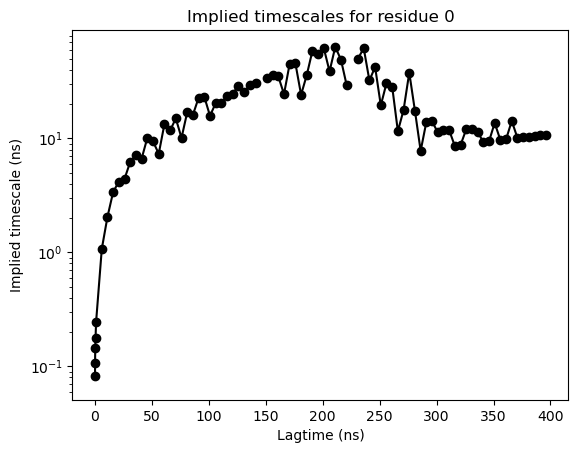

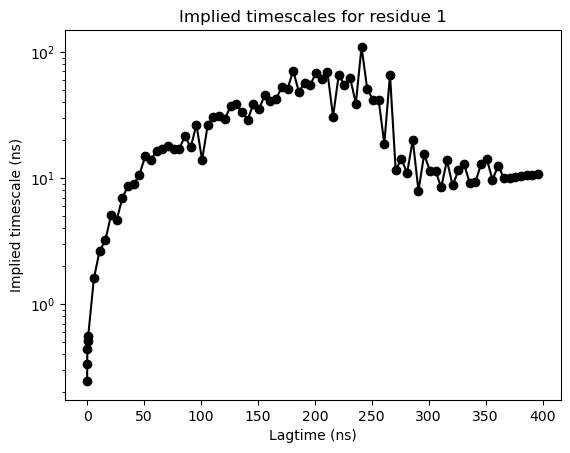

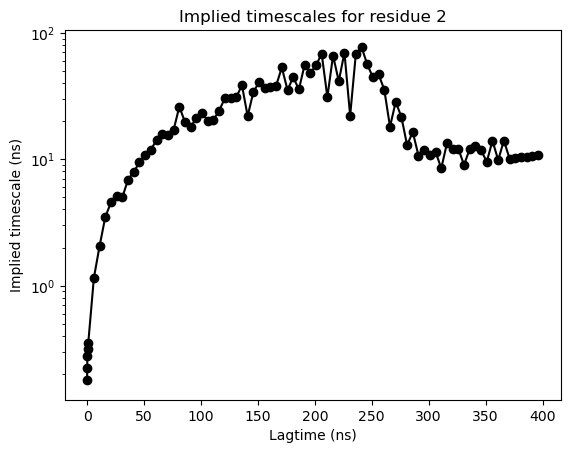

In [ ]:
# Plotting
for i, residue in enumerate(residues):
    plt.figure()
    plt.plot(lagtimes_ns, t2_all_means[i] * dt_in_ns, 'ko-')
    plt.fill_between(lagtimes_ns, 
                     (t2_all_means[i] + t2_all_stds[i]) * dt_in_ns, 
                     (t2_all_means[i] - t2_all_stds[i]) * dt_in_ns, 
                     alpha=0.2)
    plt.xlabel('Lagtime (ns)')
    plt.ylabel('Implied timescale (ns)')
    #plt.ylim(5, 1000)
    plt.yscale('log')
    plt.title(f'Implied timescales for residue {residue}')
    plt.savefig(f"autocoorel_data/implied_timescale_res{residue}.png")
    plt.show()

In [ ]:
# Create an instance of Data with your arrays
data_instance = Data([pi_all_means, pi_all_stds, 
                      t2_all_means, t2_all_stds, lagtimes_ns])

# Save to a file
data_instance.save("autocoorel_data/residue_implied_timescale.pkl")
print(f" data save at autocoorel_data/residue_implied_timescale.pkl")

 data save at autocoorel_data/residue_implied_timescale.pkl


## Load in Data and Plot

In [6]:
omega_loaded = Data.load("autocoorel_data/residue_implied_timescale.pkl").array_list
pi_all_means = omega_loaded[0]
pi_all_stds = omega_loaded[1]
t2_all_means = omega_loaded[2]
t2_all_stds = omega_loaded[3]
lagtimes_ns = omega_loaded[4]

pi_all_means.shape


(3, 84, 2)

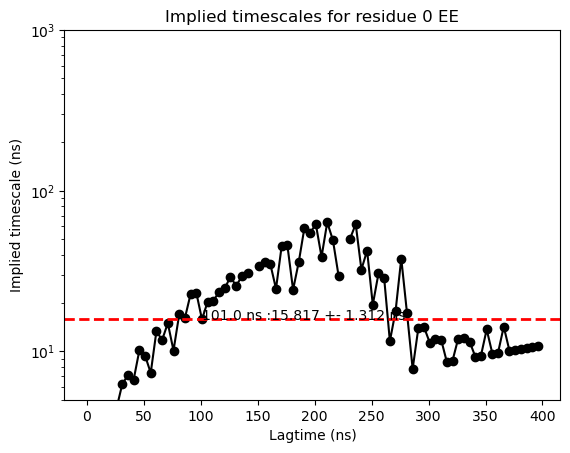

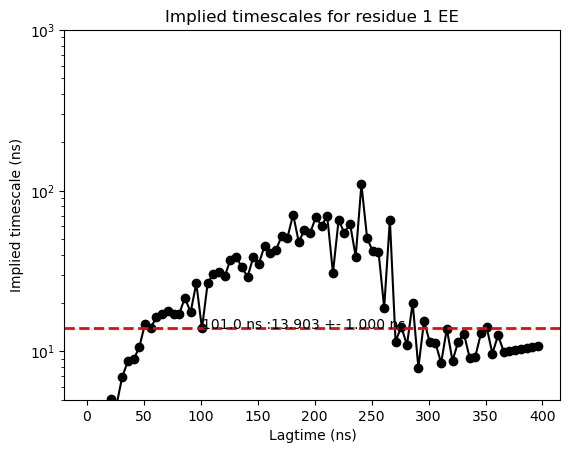

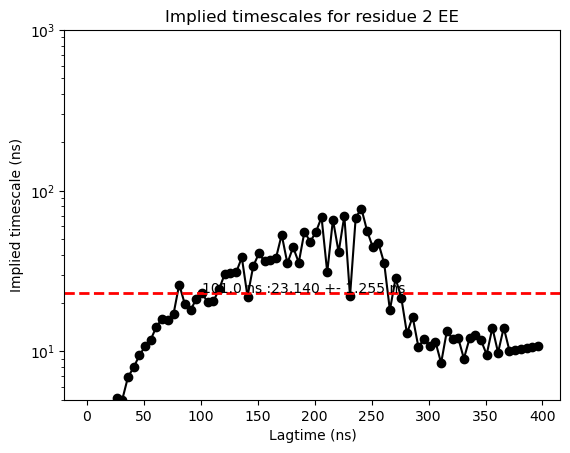

In [12]:
# Plotting
residues = [0, 1, 2]
dt_in_ns = 0.01 # 10 ps per step
for i, residue in enumerate(residues):
    plt.figure()
    plt.plot(lagtimes_ns, t2_all_means[i] * dt_in_ns, 'ko-')
    plt.fill_between(lagtimes_ns, 
                     (t2_all_means[i] + t2_all_stds[i]) * dt_in_ns, 
                     (t2_all_means[i] - t2_all_stds[i]) * dt_in_ns, 
                     alpha=0.2)

    first_x = lagtimes_ns[24]
    first_y = t2_all_means[i][24] * dt_in_ns
    first_y_var = t2_all_stds[i][24]
    plt.text(first_x, first_y, f"{first_x} ns :{first_y:.3f} +- {first_y_var:.3f} ns", fontsize=10)
    plt.axhline(y=first_y, color='r', linestyle='--', linewidth=2)

    plt.xlabel('Lagtime (ns)')
    plt.ylabel('Implied timescale (ns)')
    #plt.ylim(5, 1000)
    plt.yscale('log')
    plt.title(f'Implied timescales for residue {residue} EE')
    plt.ylim(5, 1000)
    #plt.show()
    plt.savefig(f"autocoorel_data/implied_timescale_res{residue}.png")

101.0:0.297 +- 0.009
101.0:0.703 +- 0.009


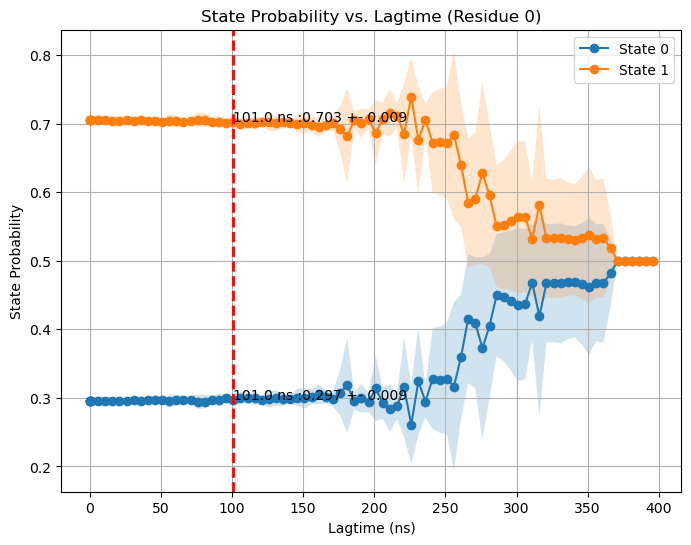

101.0:0.527 +- 0.015
101.0:0.473 +- 0.015


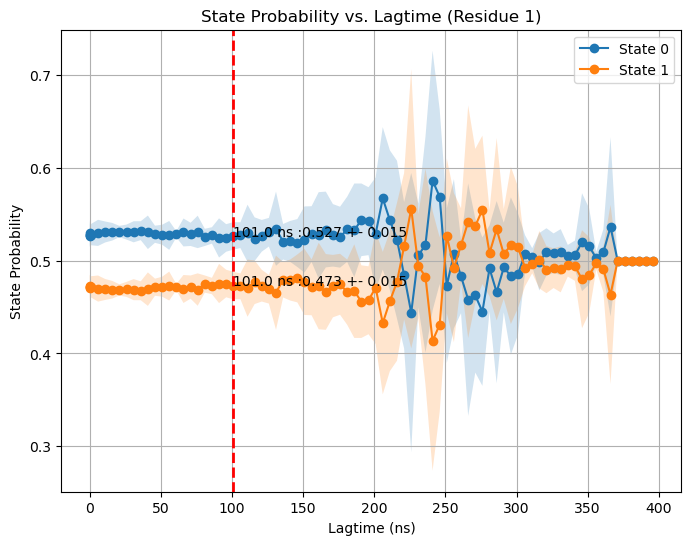

101.0:0.400 +- 0.012
101.0:0.600 +- 0.012


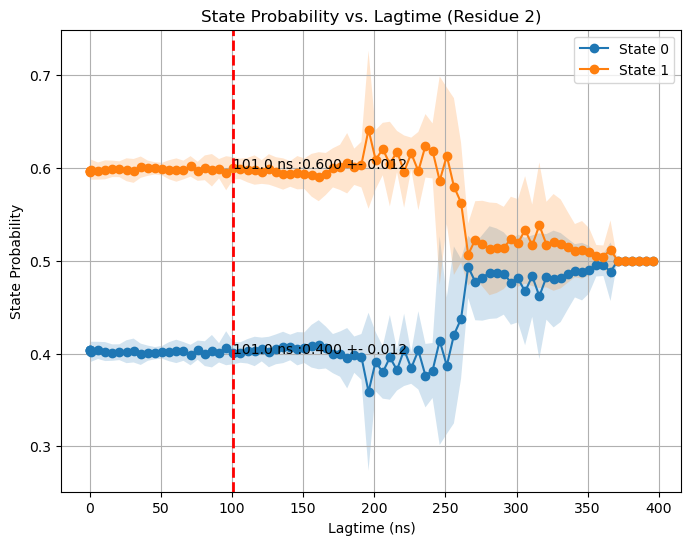

In [10]:
import matplotlib.pyplot as plt

residues = [0, 1, 2]
dt_in_ns = 0.01  # 10 ps per step
state_to_plot = [0, 1]

for res in residues:
    plt.figure(figsize=(8, 6))  # Create a new figure for each residue
    pi_means = pi_all_means[res]
    pi_stds = pi_all_stds[res] 

    for i, state in enumerate(state_to_plot):
        plt.plot(lagtimes_ns, pi_means[:, i], '-o', label=f'State {state}')
        
        # Add shaded region for standard deviation
        plt.fill_between(lagtimes_ns, 
                         pi_means[:, i] + pi_stds[:, i],  # Upper bound
                         pi_means[:, i] - pi_stds[:, i],  # Lower bound
                         alpha=0.2)
    
        # Annotate the first point with its value
        first_x = lagtimes_ns[24]
        first_y = pi_means[24, i]
        first_y_var = pi_stds[24, i]
        plt.text(first_x, first_y,  f"{first_x} ns :{first_y:.3f} +- {first_y_var:.3f}", fontsize=10)
        print(f"{first_x}:{first_y:.3f} +- {first_y_var:.3f}")
    
    plt.axvline(x=first_x, color='r', linestyle='--', linewidth=2)
    plt.xlabel("Lagtime (ns)")
    plt.ylabel("State Probability")
    plt.title(f"State Probability vs. Lagtime (Residue {res})")
    plt.legend()
    plt.grid(True)
    
    # Fix: Use `res` instead of `residue`
    plt.savefig(f"autocoorel_data/stationary_population_res{res}.png", dpi=300)
    plt.show()
